In [20]:
import cvxpy as cp
import numpy as np

In [21]:
from collections import defaultdict
N = 10
ALL_ITEMS = np.arange(N)
def update(action, item_selected, posterior_parameters, epoch_picks):
    if item_selected == N:
        n_is = [
            int(ix in action) for ix in range(N)
        ]
        v_is = [epoch_picks[i] for i in range(N)]
        posterior_parameters = [
            (a + n_is[ix], b + v_is[ix])
            for ix, (a, b) in enumerate(posterior_parameters)
        ]
        epoch_picks = defaultdict(int)
        epoch_ended = True
    else:
        epoch_picks[item_selected] += 1
        epoch_ended = False
    return posterior_parameters, epoch_picks, epoch_ended

def propose():
    return np.random.choice(
        np.arange(N, dtype=int),
        size=N,
        replace=False,
    )

def step(action, preferences):
    assert preferences[N] == 1.0
    possible_items = np.concatenate(
        [np.array([N], dtype=int), ALL_ITEMS[action]]
    )  # "no item" can always happen
    subset_preferences = preferences[possible_items]
    sum_preferences = subset_preferences.sum()
    probabilities = subset_preferences / sum_preferences
    return np.random.choice(possible_items, size=1, p=probabilities)[0]

def simulation(n_steps):
    preferences = np.random.rand(N + 1)
    preferences[-1] = 1.0
    posterior_parameters = [(1, 1) for _ in range(N)]
    epoch_picks = defaultdict(int)
    epoch_ended = True
    current_action = None
    for _ in range(n_steps):
        if epoch_ended:
            current_action = propose()
        item_picked = step(action=current_action,
                           preferences=preferences)
        posterior_parameters, epoch_picks, epoch_ended = update(action=current_action,
                                                                item_selected=item_picked,
                                                                posterior_parameters=posterior_parameters,
                                                                epoch_picks=epoch_picks)
    return preferences, posterior_parameters

def params_to_gaussian(posterior):
    gaussian_stds = np.array(
        [
            np.sqrt(b_ / a_ * ((b_ / a_) + 1) / a_)
            for (a_, b_) in posterior
        ],
    )
    gaussian_means = np.array(
        [b_ / a_ for (a_, b_) in posterior],
    )
    return gaussian_means, gaussian_stds

In [22]:
def sample_action(agent, posterior):
    agent.posterior_parameters = posterior
    return agent.proposal()

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import norm, beta

def plot_posterior(means, stds, indices=np.arange(N), ground_truth=None):
    plt.figure(figsize=(len(indices), 5))
    discretization_size = 50
    x_vals = np.linspace(0., 1., num=discretization_size)
    y_vals = []
    for ix in range(len(indices)):
        y_vals.append(norm.pdf(x_vals, loc=means[ix], scale=stds[ix])) 
    x_vals = np.concatenate([x_vals + ix for ix in range(len(indices))])
    y_vals = np.concatenate(y_vals)
    plt.plot(x_vals, y_vals)
    if ground_truth is not None:
        x_truths = [true_param + ix for ix, true_param in enumerate(ground_truth)]
        plt.vlines(x=x_truths, ymin=0., ymax=y_vals.max(), color='red', linestyles='dashed')
    plt.xticks(ticks=np.arange(len(indices)), labels=indices)
    plt.grid()
    plt.show()
    plt.close()

In [24]:
pref, posterior = simulation(25)
means, stds = params_to_gaussian(posterior)

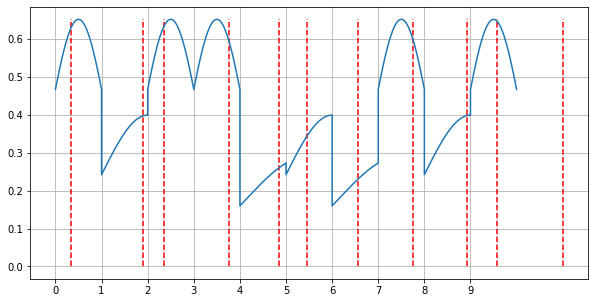

In [25]:
plot_posterior(means, stds, ground_truth=pref)

In [26]:
posterior

[(2, 1),
 (2, 2),
 (2, 1),
 (2, 1),
 (2, 3),
 (2, 2),
 (2, 3),
 (2, 1),
 (2, 2),
 (2, 1)]

In [27]:
from math import pi
from scipy.stats import geom

In [57]:
n_samples = 100

In [71]:
expected_rewards, stds = params_to_gaussian(posterior)

a_s = np.array([x[0] for x in posterior]).reshape(-1, 1)
b_s = np.array([x[1] for x in posterior]).reshape(-1, 1)

posterior_samples = 1 / beta.rvs(a=a_s, b=b_s, size=(a_s.shape[0], n_samples)) - 1

In [72]:
posterior_samples;

In [73]:
top_k = 2
best_actions = np.sort(
        np.argpartition(np.transpose(posterior_samples), -top_k, axis=1)[:, -top_k:], axis=1
        )
top_actions_dist = np.zeros(posterior_samples.shape)
for sample_ix in range(n_samples):
    top_actions_dist[best_actions[sample_ix], sample_ix] = 1.0
ps = top_actions_dist.mean(1)
entropies_start = - (ps * np.log(ps + 1e-12) + (1 - ps) * np.log(1 - ps + 1e-12))
# posterior_samples[best_actions]

In [74]:
# ps = top_actions_dist.mean(1)
ps

array([0.11, 0.17, 0.12, 0.06, 0.35, 0.29, 0.4 , 0.14, 0.18, 0.18])

In [75]:
# entropies_start = - (ps * np.log(ps + 1e-12) + (1 - ps) * np.log(1 - ps + 1e-12))
entropies_start

array([0.34651534, 0.45588621, 0.36692499, 0.22696752, 0.64744664,
       0.60215168, 0.67301167, 0.40496349, 0.47139349, 0.47139349])

In [76]:
observations_samples = geom.rvs(1 / (posterior_samples + 1)) - 1
# entropies_start = 0.5 * np.log(2 * pi * np.exp(1) * stds ** 2)
new_posterior = [[(posterior[i][0] + 1, posterior[i][1] + observations_samples[i][j]) for j in range(n_samples)] for i in range(N)]
a_s = np.array([x[0] for x in new_posterior]).reshape(-1, 1)
b_s = np.array([x[1] for x in new_posterior]).reshape(-1, 1)
posterior_samples = 1 / beta.rvs(a=a_s, b=b_s, size=(a_s.shape[0], n_samples)) - 1

In [77]:
top_k = 2
best_actions = np.sort(
        np.argpartition(np.transpose(posterior_samples), -top_k, axis=1)[:, -top_k:], axis=1
        )
top_actions_dist = np.zeros(posterior_samples.shape)
for sample_ix in range(n_samples):
    top_actions_dist[best_actions[sample_ix], sample_ix] = 1.0
ps = top_actions_dist.mean(1)
entropies_end = - (ps * np.log(ps + 1e-12) + (1 - ps) * np.log(1 - ps + 1e-12))

In [79]:
entropies_start - entropies_end

ValueError: operands could not be broadcast together with shapes (10,) (20,) 

In [320]:
a_s = np.array([x[0] for x in posterior]).reshape(-1, 1)
b_s = np.array([x[1] for x in posterior]).reshape(-1, 1)

posterior_samples = 1 / beta.rvs(a=a_s, b=b_s, size=(a_s.shape[0], n_samples)) - 1

observations_samples = geom.rvs(1 / (posterior_samples + 1)) - 1

# new_as = np.ones((N, n_samples), dtype=int)

new_posteriors = [[(posterior[i][0] + 1, posterior[i][1] + observations_samples[i][j]) for j in range(n_samples)] for i in range(N)]


new_entropies = [
    [0.5 * np.log(2 * pi * np.exp(1) * std ** 2) for std in params_to_gaussian(new_posteriors[i])[1]]
    for i in range(N)
]

new_entropies = np.array(new_entropies)

new_entropies = new_entropies.mean(1)

reductions = entropies_start - new_entropies
reductions

array([0.12188799, 0.11699666, 0.08320878, 0.09020289, 0.08765731,
       0.07867499, 0.07671157, 0.14857892, 0.12256875, 0.10547239])

In [294]:
expected_rewards

array([0.4, 0.2, 0.4, 0.4, 0.8, 0.8, 0.2, 0.4, 0.8, 0.6])

In [295]:
K = 2

In [297]:
from ts_agents import EpochSamplingTS
ts_cs_agent = EpochSamplingTS(k=K, n=N, horizon=10000, sampling=1, limited_prefs=False)
ts_cs_agent.posterior_parameters = posterior

Agent believes first=best? False


In [311]:
ts_cs_action = ts_cs_agent.proposal()
ts_cs_action

array([5, 8])

In [312]:
from ids_utils import info_gain_step, numba_expected_reward
from env import act_optimally

In [313]:
posterior_samples = np.transpose(posterior_samples)

In [314]:
# sorted_beliefs = np.sort(posterior_samples, axis=1)[
#     :, -K :
# ]  # shape (m, k)
# picking_probabilities = sorted_beliefs.sum(1)
# r_star = picking_probabilities.mean()
# a_greedy = act_optimally(
#     posterior_samples.mean(0), K
# )
# greedy_expected_reward = numba_expected_reward(
#     posterior_samples, a_greedy, mode="step"
# )
# delta_min = r_star - greedy_expected_reward
# assert delta_min > -1e-12
# delta_min = max(1e-12, delta_min)

# posteriors_actions = act_optimally(
#     posterior_samples, K
# )
# posteriors_actions = [
#     tuple(posteriors_actions[ix, :]) for ix in range(n_samples)
# ]
# optimal_actions_information = defaultdict(list)
# for ix, action in enumerate(posteriors_actions):
#     optimal_actions_information[action].append(ix)

# optimal_actions = {
#     action: (len(theta_idxs) / n_samples, theta_idxs)
#     for action, theta_idxs in optimal_actions_information.items()
# }
# actions_star = np.array(
#     [list(key) for key in optimal_actions_information.keys()]
# )
# counts_star = np.array(
#     [len(val) for val in optimal_actions_information.values()]
# )
# thetas_star = []
# for val in optimal_actions_information.values():
#     thetas_star += val
# thetas_star = np.array(thetas_star)
# gain_ts_cs = info_gain_step(action=ts_cs_action,
#                             sampled_preferences=posterior_samples,
#                             actions_star=actions_star,
#                             counts=counts_star,
#                             thetas=thetas_star)

In [315]:
ts_cs_gain = reductions[ts_cs_action].sum()

In [316]:
ts_cs_gain

0.1514313513425315

In [317]:
expected_rewards

array([0.4, 0.2, 0.4, 0.4, 0.8, 0.8, 0.2, 0.4, 0.8, 0.6])

In [318]:
x = cp.Variable(N)

objective = cp.Maximize(expected_rewards @ x )
constraints = [0 <= x, x <= 1, cp.sum(x) == K, x @ reductions >= ts_cs_gain]
prob = cp.Problem(objective, constraints,
                 )
prob.solve(solver='ECOS')

1.5999999999657704

In [321]:
x.value

array([6.60163947e-12, 1.55660819e-11, 1.11970893e-11, 1.00285826e-11,
       6.89156019e-01, 6.91680541e-01, 1.25387555e-11, 8.57107638e-12,
       6.19163440e-01, 1.40261979e-11])

In [323]:
np.argmax(x.value, 3)

AxisError: axis 3 is out of bounds for array of dimension 1

In [325]:
act_optimally(
            np.squeeze(x.value), top_k=K
        )

array([4, 5])